# Project 1
## Setting up dataframes

In [2]:
import json  
import csv   
import os    
import pandas as pd  
import numpy as np   

# Reading json file into dataframe
outfile = open("review_stars.tsv", 'w')

sfile = csv.writer(outfile, delimiter = "\t", quoting = csv.QUOTE_MINIMAL)

sfile.writerow(['business_id', 'stars', 'text'])

# Opening yelp_academic_dataset_review json 
with open('yelp_academic_dataset_review.json', encoding = "utf-8") as f:
    for line in f:
        row = json.loads(line)        
        sfile.writerow([row['business_id'], row['stars'], row['text'].encode('utf-8')])
outfile.close()

# Read the 'review_stars.tsv' file into a pandas DataFrame
df_reviews = pd.read_csv('review_stars.tsv', delimiter = "\t", encoding = "utf-8")
df_reviews[0:5] # Displaying first 5 rows


,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"b""If you decide to eat here, just be aware it ..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,"b""I've taken a lot of spin classes over the ye..."
2,YjUWPpI6HXG530lwP-fb2A,3.0,b'Family diner. Had the buffet. Eclectic assor...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,"b""Wow! Yummy, different, delicious. Our fa..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,"b""Cute interior and owner (?) gave us tour of ..."


In [3]:
outfile = open("businesses.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id', 'name', 'stars', 'categories','review_count'])

# Opening yelp_academic_dataset_business json 

with open('yelp_academic_dataset_business.json',encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        sfile.writerow([row['business_id'], row['name'], row['stars'], row['categories'],row['review_count']])
outfile.close()

df_businesses = pd.read_csv('businesses.tsv', delimiter = "\t", encoding = "utf-8")
df_businesses[0:5] # Displaying first 5 rows

,business_id,name,stars,categories,review_count
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",5.0,"Doctors, Traditional Chinese Medicine, Naturop...",7
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,3.0,"Shipping Centers, Local Services, Notaries, Ma...",15
2,tUFrWirKiKi_TAnsVWINQQ,Target,3.5,"Department Stores, Shopping, Fashion, Home & G...",22
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,4.5,"Brewpubs, Breweries, Food",13


## Removing records with less than 20 reviews

In [4]:
df_businesses.shape # Before removal

(150346, 5)

In [5]:
# Dropping any records with less than 20 reviews
df_businesses = df_businesses[df_businesses['review_count'] >= 20]

In [6]:
df_businesses.shape # After removal

(61919, 5)

## Merging review and business dataframes

In [7]:
# Group reviews by business_id and concatenate all review texts for each business
df_reviews_grouped = df_reviews.groupby('business_id')['text'].sum()

# Reset index to turn 'business_id' from an index into a regular column
df_reviews_grouped = df_reviews_grouped.reset_index()

# Create new dataframe with business_id and the combined reviews 
df_ready_for_sklearn = pd.DataFrame({'business_id': df_reviews_grouped['business_id'], 'all_reviews': df_reviews_grouped['text']})

# Merge the reviews dataframe with the business on 'business_id' column
df_merge = pd.merge(df_ready_for_sklearn, df_businesses, on = 'business_id')


In [8]:
df_merge[0:5] # Merged dataframe, display 

,business_id,all_reviews,name,stars,categories,review_count
0,---kPU91CF4Lq2-WlRu9Lw,"b""Ate here for the 1st time on Saturday 08/07/...",Frankie's Raw Bar,4.5,"Seafood, Restaurants, Latin American, Food, Fo...",24
1,--8IbOsAAxjKRoYsBFL-PA,"b'Took me for 40 bucks through grubhub, no cal...",The Original Italian Pie,3.0,"Food, Restaurants, Italian",27
2,--9osgUCSDUWUkoTLdvYhQ,b'I loved this!!!! I was set up on a blind dat...,Will You Escape?,5.0,"Active Life, Challenge Courses, Escape Games",29
3,--ARBQr1WMsTWiwOKOj-FQ,b'What a great neighborhood place to wine it u...,Traveling Corks,4.5,"Wine Bars, Nightlife, Bars",23
4,--FcbSxK1AoEtEAxOgBaCw,"b""This is my go to car wash establishment. Tod...",Victory Car Wash,3.5,"Car Wash, Automotive",40


In [9]:
df_merge.shape

(61919, 6)

## TF-IDF model

In [10]:
import sklearn.feature_extraction.text as sk_text

# min_df=2 ignore terms that appear in fewer than 2 documents
# max_df=0.8 ignore terms that appear in more than 80% of documents 
vectorizer = sk_text.TfidfVectorizer(stop_words = 'english', max_features = 1000, min_df=2, max_df=0.8)

matrix = vectorizer.fit_transform(df_merge['all_reviews'])
print(type(matrix))

tf_data = matrix.toarray()
pd.set_option('display.max_colwidth', None)
print(tf_data)
print(vectorizer.get_feature_names_out())

<class 'scipy.sparse._csr.csr_matrix'>
[[0.         0.         0.         ... 0.02400581 0.03107729 0.        ]
 [0.02006421 0.         0.         ... 0.         0.         0.0215981 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.02144795 0.         0.         ... 0.02148839 0.         0.        ]
 [0.         0.         0.         ... 0.03029127 0.         0.03254565]
 [0.12028862 0.02505155 0.         ... 0.02410308 0.         0.        ]]
['00' '100' '11' '12' '15' '20' '25' '30' '40' '45' '50' 'able' 'absolute'
 'absolutely' 'accommodating' 'actual' 'add' 'added' 'addition'
 'affordable' 'afternoon' 'ago' 'ahead' 'air' 'airport' 'ambiance'
 'american' 'answer' 'app' 'apparently' 'appetizer' 'appetizers' 'apple'
 'appointment' 'appreciate' 'aren' 'arrived' 'art' 'asian' 'asking' 'ate'
 'atmosphere' 'attention' 'attentive' 'attitude' 'authentic' 'available'
 'average' 'avocado' 'avoid' 'awful' 'baby' 'bacon' 'bag' 'baked' 'bar'
 'barbara' 'barely'

## Train/test split

In [11]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [12]:
y = df_merge['stars'] # Assigning 'star' to y

In [13]:
y.shape

(61919,)

In [14]:
tf_data.shape

(61919, 1000)

In [15]:
review_arr = df_merge['review_count'].values
review_arr.shape
concat_rev = np.vstack(review_arr) # converts the 1D array into a shape suitable for concatenation
x = np.concatenate((tf_data, concat_rev), axis=1) # Creates a single feature matrix 'x' using tf-idf data
x.shape

(61919, 1001)

In [16]:
# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=77)

# Printing the shapes of the training and test sets to confirm the split
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Creating an array copy of the test target values 
y_test_copy = y_test

(46439, 1001)
(46439,)
(15480, 1001)
(15480,)


## Experimenting different models (Relu, sigmoid, tanh) 
### Relu model with 'adam' optimizer

In [16]:
# Save models into path dir
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "relu_adam_model.keras"), 
                               verbose=0, save_best_only=True)

# Run for 3 times
for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_model = Sequential()
    relu_model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
    relu_model.add(Dense(10, activation='relu'))
    relu_model.add(Dense(1))

    relu_model.compile(loss='mean_squared_error', optimizer='adam')

    # Stops when model stops improving
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
    relu_model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1452/1452 - 1s - 990us/step - loss: 1.4483 - val_loss: 0.2379
Epoch 2/1000
1452/1452 - 1s - 595us/step - loss: 0.2270 - val_loss: 0.1506
Epoch 3/1000
1452/1452 - 1s - 638us/step - loss: 0.2495 - val_loss: 0.1313
Epoch 4/1000
1452/1452 - 1s - 584us/step - loss: 0.4342 - val_loss: 0.1349
Epoch 5/1000
1452/1452 - 1s - 583us/step - loss: 0.1330 - val_loss: 0.1533
Epoch 6/1000
1452/1452 - 1s - 582us/step - loss: 0.1118 - val_loss: 0.5292
Epoch 6: early stopping

Run:  2
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 944us/step - loss: 1.9025 - val_loss: 2.7884
Epoch 2/1000
1452/1452 - 1s - 589us/step - loss: 0.2582 - val_loss: 0.1498
Epoch 3/1000
1452/1452 - 1s - 599us/step - loss: 0.3954 - val_loss: 0.1681
Epoch 4/1000
1452/1452 - 1s - 601us/step - loss: 0.1461 - val_loss: 0.1243
Epoch 5/1000
1452/1452 - 1s - 583us/step - loss: 0.1349 - val_loss: 0.1269
Epoch 6/1000
1452/1452 - 1s - 619us/step - loss: 0.1949 - val_loss: 0.1069
Epoch 7/1000
1452/1452 - 1s - 583us/step - loss: 0.1221 - val_loss: 0.0993
Epoch 8/1000
1452/1452 - 1s - 611us/step - loss: 0.1171 - val_loss: 0.0959
Epoch 9/1000
1452/1452 - 1s - 617us/step - loss: 0.1275 - val_loss: 0.1037
Epoch 10/1000
1452/1452 - 1s - 587us/step - loss: 0.0976 - val_loss: 0.0971
Epoch 11/1000
1452/1452 - 1s - 594us/step - loss: 0.1023 - val_loss: 0.0883
Epoch 12/1000
1452/1452 - 1s - 599us/step - loss: 0.1039 - val_loss: 0.0832
Epoch 13/1000
1452/1452 - 1s - 583us/step - loss: 0.1013 - val_loss: 0.0901
Epoch 14/1000
1452/1452 - 1s - 607

/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 960us/step - loss: 3.5374 - val_loss: 0.6449
Epoch 2/1000
1452/1452 - 1s - 585us/step - loss: 0.2837 - val_loss: 0.2134
Epoch 3/1000
1452/1452 - 1s - 581us/step - loss: 0.2182 - val_loss: 0.1423
Epoch 4/1000
1452/1452 - 1s - 582us/step - loss: 0.1982 - val_loss: 0.1348
Epoch 5/1000
1452/1452 - 1s - 588us/step - loss: 0.4142 - val_loss: 0.1375
Epoch 6/1000
1452/1452 - 1s - 649us/step - loss: 0.1228 - val_loss: 0.1134
Epoch 7/1000
1452/1452 - 1s - 582us/step - loss: 0.1148 - val_loss: 0.1050
Epoch 8/1000
1452/1452 - 1s - 581us/step - loss: 0.1305 - val_loss: 0.1008
Epoch 9/1000
1452/1452 - 1s - 581us/step - loss: 0.1204 - val_loss: 0.1401
Epoch 10/1000
1452/1452 - 1s - 607us/step - loss: 0.1323 - val_loss: 0.1028
Epoch 11/1000
1452/1452 - 1s - 579us/step - loss: 0.1206 - val_loss: 0.1012
Epoch 11: early stopping


### Relu model with 'sgd' optimizer. Added layers and increased neuron count

In [17]:
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "relu_sgd_model.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    relu_modelv2 = Sequential()

    relu_modelv2.add(Dense(50, input_dim=x.shape[1], activation='relu')) # increased neurons 50
    relu_modelv2.add(Dense(25, activation='relu')) # new layer
    relu_modelv2.add(Dense(25, activation='relu')) # new layer
    relu_modelv2.add(Dense(10, activation='relu'))
    relu_modelv2.add(Dense(1))

    relu_modelv2.compile(loss='mean_squared_error', optimizer='sgd') # Activation set sgd

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    relu_modelv2.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 874us/step - loss: 927400074412032.0000 - val_loss: 0.7039
Epoch 2/1000
1452/1452 - 1s - 638us/step - loss: 0.7084 - val_loss: 0.7041
Epoch 3/1000
1452/1452 - 1s - 644us/step - loss: 0.7084 - val_loss: 0.7040
Epoch 4/1000
1452/1452 - 1s - 640us/step - loss: 0.7084 - val_loss: 0.7040
Epoch 4: early stopping

Run:  2
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 794us/step - loss: nan - val_loss: nan
Epoch 2/1000
1452/1452 - 1s - 644us/step - loss: nan - val_loss: nan
Epoch 3/1000
1452/1452 - 1s - 642us/step - loss: nan - val_loss: nan
Epoch 3: early stopping

Run:  3
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 794us/step - loss: nan - val_loss: nan
Epoch 2/1000
1452/1452 - 1s - 649us/step - loss: nan - val_loss: nan
Epoch 3/1000
1452/1452 - 1s - 628us/step - loss: nan - val_loss: nan
Epoch 3: early stopping


### Sigmoid model with 'adam' optimizer

In [18]:
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "sigmoid_adam_model.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    sig_model = Sequential()
    sig_model.add(Dense(25, input_dim=x.shape[1], activation='sigmoid'))
    sig_model.add(Dense(10, activation='sigmoid'))
    sig_model.add(Dense(1))

    sig_model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    sig_model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 958us/step - loss: 1.2632 - val_loss: 0.5724
Epoch 2/1000
1452/1452 - 1s - 592us/step - loss: 0.2072 - val_loss: 0.1098
Epoch 3/1000
1452/1452 - 1s - 638us/step - loss: 0.1012 - val_loss: 0.1057
Epoch 4/1000
1452/1452 - 1s - 596us/step - loss: 0.0908 - val_loss: 0.0865
Epoch 5/1000
1452/1452 - 1s - 586us/step - loss: 0.0853 - val_loss: 0.0882
Epoch 6/1000
1452/1452 - 1s - 592us/step - loss: 0.0825 - val_loss: 0.0810
Epoch 7/1000
1452/1452 - 1s - 591us/step - loss: 0.0810 - val_loss: 0.0797
Epoch 8/1000
1452/1452 - 1s - 585us/step - loss: 0.0798 - val_loss: 0.0802
Epoch 9/1000
1452/1452 - 1s - 584us/step - loss: 0.0777 - val_loss: 0.0824
Epoch 10/1000
1452/1452 - 1s - 588us/step - loss: 0.0771 - val_loss: 0.0790
Epoch 11/1000
1452/1452 - 1s - 592us/step - loss: 0.0760 - val_loss: 0.0780
Epoch 12/1000
1452/1452 - 1s - 586us/step - loss: 0.0762 - val_loss: 0.0793
Epoch 13/1000
1452/1452 - 1s - 594us/step - loss: 0.0746 - val_loss: 0.0760
Epoch 14/1000
1452/1452 - 1s - 584

/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 1ms/step - loss: 1.0181 - val_loss: 0.2159
Epoch 2/1000
1452/1452 - 1s - 587us/step - loss: 0.1338 - val_loss: 0.1007
Epoch 3/1000
1452/1452 - 1s - 584us/step - loss: 0.0961 - val_loss: 0.0935
Epoch 4/1000
1452/1452 - 1s - 587us/step - loss: 0.0877 - val_loss: 0.0880
Epoch 5/1000
1452/1452 - 1s - 586us/step - loss: 0.0835 - val_loss: 0.0808
Epoch 6/1000
1452/1452 - 1s - 584us/step - loss: 0.0810 - val_loss: 0.0861
Epoch 7/1000
1452/1452 - 1s - 585us/step - loss: 0.0802 - val_loss: 0.0781
Epoch 8/1000
1452/1452 - 1s - 586us/step - loss: 0.0781 - val_loss: 0.0828
Epoch 9/1000
1452/1452 - 1s - 588us/step - loss: 0.0764 - val_loss: 0.0772
Epoch 10/1000
1452/1452 - 1s - 586us/step - loss: 0.0752 - val_loss: 0.0772
Epoch 11/1000
1452/1452 - 1s - 584us/step - loss: 0.0742 - val_loss: 0.0796
Epoch 12/1000
1452/1452 - 1s - 585us/step - loss: 0.0738 - val_loss: 0.0755
Epoch 13/1000
1452/1452 - 1s - 584us/step - loss: 0.0727 - val_loss: 0.0765
Epoch 14/1000
1452/1452 - 1s - 583us

/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 942us/step - loss: 1.1269 - val_loss: 0.3210
Epoch 2/1000
1452/1452 - 1s - 584us/step - loss: 0.1561 - val_loss: 0.1153
Epoch 3/1000
1452/1452 - 1s - 620us/step - loss: 0.0982 - val_loss: 0.0988
Epoch 4/1000
1452/1452 - 1s - 582us/step - loss: 0.0893 - val_loss: 0.0891
Epoch 5/1000
1452/1452 - 1s - 583us/step - loss: 0.0848 - val_loss: 0.0827
Epoch 6/1000
1452/1452 - 1s - 582us/step - loss: 0.0822 - val_loss: 0.0838
Epoch 7/1000
1452/1452 - 1s - 582us/step - loss: 0.0811 - val_loss: 0.0802
Epoch 8/1000
1452/1452 - 1s - 582us/step - loss: 0.0786 - val_loss: 0.0795
Epoch 9/1000
1452/1452 - 1s - 583us/step - loss: 0.0773 - val_loss: 0.0784
Epoch 10/1000
1452/1452 - 1s - 583us/step - loss: 0.0763 - val_loss: 0.0774
Epoch 11/1000
1452/1452 - 1s - 584us/step - loss: 0.0754 - val_loss: 0.0770
Epoch 12/1000
1452/1452 - 1s - 583us/step - loss: 0.0751 - val_loss: 0.0770
Epoch 13/1000
1452/1452 - 1s - 582us/step - loss: 0.0746 - val_loss: 0.0769
Epoch 14/1000
1452/1452 - 1s - 583

### Sigmoid model with 'sgd' optimizer. Added layers and increased neuron count

In [19]:
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "sigmoid_sgd_model.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    sig_modelv2 = Sequential()
    sig_modelv2.add(Dense(50, input_dim=x.shape[1], activation='sigmoid')) # set to 50 neurons
    sig_modelv2.add(Dense(20, activation='sigmoid')) # added layer
    sig_modelv2.add(Dense(20, activation='sigmoid')) # added layer
    sig_modelv2.add(Dense(10, activation='sigmoid'))
    sig_modelv2.add(Dense(1))

    sig_modelv2.compile(loss='mean_squared_error', optimizer='sgd') # set to sgd 

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    sig_modelv2.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 803us/step - loss: 0.7653 - val_loss: 0.7098
Epoch 2/1000
1452/1452 - 1s - 639us/step - loss: 0.7080 - val_loss: 0.7043
Epoch 3/1000
1452/1452 - 1s - 716us/step - loss: 0.7071 - val_loss: 0.7013
Epoch 4/1000
1452/1452 - 1s - 636us/step - loss: 0.7070 - val_loss: 0.7006
Epoch 5/1000
1452/1452 - 1s - 635us/step - loss: 0.7061 - val_loss: 0.6999
Epoch 6/1000
1452/1452 - 1s - 627us/step - loss: 0.7053 - val_loss: 0.7078
Epoch 7/1000
1452/1452 - 1s - 634us/step - loss: 0.7043 - val_loss: 0.6981
Epoch 8/1000
1452/1452 - 1s - 636us/step - loss: 0.7033 - val_loss: 0.6974
Epoch 9/1000
1452/1452 - 1s - 636us/step - loss: 0.7019 - val_loss: 0.6958
Epoch 10/1000
1452/1452 - 1s - 628us/step - loss: 0.7011 - val_loss: 0.7109
Epoch 11/1000
1452/1452 - 1s - 624us/step - loss: 0.6997 - val_loss: 0.7001
Epoch 12/1000
1452/1452 - 1s - 637us/step - loss: 0.6987 - val_loss: 0.6921
Epoch 13/1000
1452/1452 - 1s - 631us/step - loss: 0.6974 - val_loss: 0.6932
Epoch 14/1000
1452/1452 - 1s - 635

/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 788us/step - loss: 0.7300 - val_loss: 0.7015
Epoch 2/1000
1452/1452 - 1s - 625us/step - loss: 0.7061 - val_loss: 0.7015
Epoch 3/1000
1452/1452 - 1s - 663us/step - loss: 0.7048 - val_loss: 0.7000
Epoch 4/1000
1452/1452 - 1s - 628us/step - loss: 0.7036 - val_loss: 0.6985
Epoch 5/1000
1452/1452 - 1s - 628us/step - loss: 0.7019 - val_loss: 0.6967
Epoch 6/1000
1452/1452 - 1s - 624us/step - loss: 0.7006 - val_loss: 0.6940
Epoch 7/1000
1452/1452 - 1s - 624us/step - loss: 0.6990 - val_loss: 0.6990
Epoch 8/1000
1452/1452 - 1s - 626us/step - loss: 0.6978 - val_loss: 0.7104
Epoch 9/1000
1452/1452 - 1s - 628us/step - loss: 0.6969 - val_loss: 0.6909
Epoch 10/1000
1452/1452 - 1s - 628us/step - loss: 0.6957 - val_loss: 0.6888
Epoch 11/1000
1452/1452 - 1s - 626us/step - loss: 0.6951 - val_loss: 0.6937
Epoch 12/1000
1452/1452 - 1s - 625us/step - loss: 0.6948 - val_loss: 0.6987
Epoch 13/1000
1452/1452 - 1s - 633us/step - loss: 0.6942 - val_loss: 0.6870
Epoch 14/1000
1452/1452 - 1s - 626

/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 780us/step - loss: 0.7432 - val_loss: 0.7007
Epoch 2/1000
1452/1452 - 1s - 622us/step - loss: 0.7055 - val_loss: 0.6998
Epoch 3/1000
1452/1452 - 1s - 625us/step - loss: 0.7046 - val_loss: 0.7000
Epoch 4/1000
1452/1452 - 1s - 632us/step - loss: 0.7038 - val_loss: 0.6995
Epoch 5/1000
1452/1452 - 1s - 628us/step - loss: 0.7024 - val_loss: 0.6967
Epoch 6/1000
1452/1452 - 1s - 627us/step - loss: 0.7014 - val_loss: 0.6965
Epoch 7/1000
1452/1452 - 1s - 626us/step - loss: 0.7005 - val_loss: 0.6962
Epoch 8/1000
1452/1452 - 1s - 622us/step - loss: 0.6989 - val_loss: 0.7018
Epoch 9/1000
1452/1452 - 1s - 627us/step - loss: 0.6981 - val_loss: 0.7041
Epoch 10/1000
1452/1452 - 1s - 625us/step - loss: 0.6969 - val_loss: 0.6900
Epoch 11/1000
1452/1452 - 1s - 628us/step - loss: 0.6957 - val_loss: 0.6896
Epoch 12/1000
1452/1452 - 1s - 630us/step - loss: 0.6953 - val_loss: 0.6926
Epoch 13/1000
1452/1452 - 1s - 625us/step - loss: 0.6948 - val_loss: 0.6874
Epoch 14/1000
1452/1452 - 1s - 638

### Tanh model with 'adam' optimizer

In [20]:
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "tanh_adam_model.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_model = Sequential()
    tanh_model.add(Dense(25, input_dim=x.shape[1], activation='tanh'))
    tanh_model.add(Dense(10, activation='tanh'))
    tanh_model.add(Dense(1))

    tanh_model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    tanh_model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 964us/step - loss: 0.6205 - val_loss: 0.1037
Epoch 2/1000
1452/1452 - 1s - 600us/step - loss: 0.0967 - val_loss: 0.0853
Epoch 3/1000
1452/1452 - 1s - 584us/step - loss: 0.0858 - val_loss: 0.1137
Epoch 4/1000
1452/1452 - 1s - 588us/step - loss: 0.0819 - val_loss: 0.0804
Epoch 5/1000
1452/1452 - 1s - 578us/step - loss: 0.0796 - val_loss: 0.0889
Epoch 6/1000
1452/1452 - 1s - 579us/step - loss: 0.0790 - val_loss: 0.0811
Epoch 7/1000
1452/1452 - 1s - 589us/step - loss: 0.0771 - val_loss: 0.0783
Epoch 8/1000
1452/1452 - 1s - 586us/step - loss: 0.0744 - val_loss: 0.0760
Epoch 9/1000
1452/1452 - 1s - 580us/step - loss: 0.0759 - val_loss: 0.0802
Epoch 10/1000
1452/1452 - 1s - 592us/step - loss: 0.0753 - val_loss: 0.0820
Epoch 11/1000
1452/1452 - 1s - 621us/step - loss: 0.0738 - val_loss: 0.0807
Epoch 11: early stopping

Run:  2
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 945us/step - loss: 0.5676 - val_loss: 0.1032
Epoch 2/1000
1452/1452 - 1s - 587us/step - loss: 0.0965 - val_loss: 0.0924
Epoch 3/1000
1452/1452 - 1s - 584us/step - loss: 0.0883 - val_loss: 0.1009
Epoch 4/1000
1452/1452 - 1s - 586us/step - loss: 0.0826 - val_loss: 0.0836
Epoch 5/1000
1452/1452 - 1s - 584us/step - loss: 0.0839 - val_loss: 0.0804
Epoch 6/1000
1452/1452 - 1s - 583us/step - loss: 0.0794 - val_loss: 0.0774
Epoch 7/1000
1452/1452 - 1s - 582us/step - loss: 0.0778 - val_loss: 0.0832
Epoch 8/1000
1452/1452 - 1s - 585us/step - loss: 0.0783 - val_loss: 0.0803
Epoch 9/1000
1452/1452 - 1s - 587us/step - loss: 0.0751 - val_loss: 0.0819
Epoch 9: early stopping

Run:  3
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 939us/step - loss: 0.3979 - val_loss: 0.1100
Epoch 2/1000
1452/1452 - 1s - 579us/step - loss: 0.0973 - val_loss: 0.0890
Epoch 3/1000
1452/1452 - 1s - 588us/step - loss: 0.0878 - val_loss: 0.0858
Epoch 4/1000
1452/1452 - 1s - 582us/step - loss: 0.0851 - val_loss: 0.1052
Epoch 5/1000
1452/1452 - 1s - 581us/step - loss: 0.0806 - val_loss: 0.0822
Epoch 6/1000
1452/1452 - 1s - 583us/step - loss: 0.0803 - val_loss: 0.0847
Epoch 7/1000
1452/1452 - 1s - 580us/step - loss: 0.0793 - val_loss: 0.0792
Epoch 8/1000
1452/1452 - 1s - 607us/step - loss: 0.0800 - val_loss: 0.0855
Epoch 9/1000
1452/1452 - 1s - 581us/step - loss: 0.0771 - val_loss: 0.0765
Epoch 10/1000
1452/1452 - 1s - 582us/step - loss: 0.0765 - val_loss: 0.0784
Epoch 11/1000
1452/1452 - 1s - 582us/step - loss: 0.0752 - val_loss: 0.0782
Epoch 12/1000
1452/1452 - 1s - 588us/step - loss: 0.0745 - val_loss: 0.0750
Epoch 13/1000
1452/1452 - 1s - 583us/step - loss: 0.0758 - val_loss: 0.0839
Epoch 14/1000
1452/1452 - 1s - 580

### Tanh model with 'sgd' optimizer. Added layers and increased neuron count

In [21]:
saved_path = './Prj1Models/'
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_path, "tanh_sgd_model.keras"), 
                               verbose=0, save_best_only=True)

for i in range(3):
    print('\nRun: ', i + 1)
    
    tanh_modelv2 = Sequential()
    tanh_modelv2.add(Dense(50, input_dim=x.shape[1], activation='tanh')) # Set to 50 neurons
    tanh_modelv2.add(Dense(20, activation='tanh')) # added layer
    tanh_modelv2.add(Dense(20, activation='tanh')) # added layer
    tanh_modelv2.add(Dense(10, activation='tanh'))
    tanh_modelv2.add(Dense(1))

    tanh_modelv2.compile(loss='mean_squared_error', optimizer='sgd') # set to sgd 

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')

    tanh_modelv2.fit(x_train, y_train, validation_data=(x_test, y_test), 
                   callbacks=[monitor, checkpointer], verbose=2, epochs=1000)


Run:  1
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 799us/step - loss: 0.7108 - val_loss: 0.7277
Epoch 2/1000
1452/1452 - 1s - 638us/step - loss: 0.7029 - val_loss: 0.6939
Epoch 3/1000
1452/1452 - 1s - 632us/step - loss: 0.7051 - val_loss: 0.6975
Epoch 4/1000
1452/1452 - 1s - 632us/step - loss: 0.7028 - val_loss: 0.6951
Epoch 5/1000
1452/1452 - 1s - 633us/step - loss: 0.7040 - val_loss: 0.6945
Epoch 5: early stopping

Run:  2
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 833us/step - loss: 0.7126 - val_loss: 0.8410
Epoch 2/1000
1452/1452 - 1s - 640us/step - loss: 0.7032 - val_loss: 0.6927
Epoch 3/1000
1452/1452 - 1s - 639us/step - loss: 0.7044 - val_loss: 0.7366
Epoch 4/1000
1452/1452 - 1s - 633us/step - loss: 0.7033 - val_loss: 0.6972
Epoch 5/1000
1452/1452 - 1s - 636us/step - loss: 0.7033 - val_loss: 0.7714
Epoch 5: early stopping

Run:  3
Epoch 1/1000


/Users/yahir/anaconda3/envs/testenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1452/1452 - 1s - 788us/step - loss: 0.7193 - val_loss: 0.6934
Epoch 2/1000
1452/1452 - 1s - 629us/step - loss: 0.7016 - val_loss: 0.6903
Epoch 3/1000
1452/1452 - 1s - 631us/step - loss: 0.7016 - val_loss: 0.6924
Epoch 4/1000
1452/1452 - 1s - 635us/step - loss: 0.6997 - val_loss: 0.6883
Epoch 5/1000
1452/1452 - 1s - 634us/step - loss: 0.7017 - val_loss: 0.6898
Epoch 6/1000
1452/1452 - 1s - 630us/step - loss: 0.7001 - val_loss: 0.6991
Epoch 7/1000
1452/1452 - 1s - 635us/step - loss: 0.7022 - val_loss: 0.7056
Epoch 7: early stopping


In [22]:
from keras.models import load_model
from sklearn import metrics

### Loading saved models

In [23]:
relu_adam_load = load_model(os.path.join(saved_path, "relu_adam_model.keras"))
relu_sgd_load = load_model(os.path.join(saved_path, "relu_sgd_model.keras"))
sigmoid_adam_load = load_model(os.path.join(saved_path, "sigmoid_adam_model.keras"))
sigmoid_sgd_load = load_model(os.path.join(saved_path, "sigmoid_sgd_model.keras"))
tanh_adam_load = load_model(os.path.join(saved_path, "tanh_adam_model.keras"))
tanh_sgd_load = load_model(os.path.join(saved_path, "tanh_sgd_model.keras"))

## Determining best model

In [24]:
# Create a dictionary of models and their predictions for simplicity
predictions = {
    'Relu Model (Adam)': relu_adam_load.predict(x_test),
    'Relu Model (SGD)': relu_sgd_load.predict(x_test),
    'Sigmoid Model (Adam)': sigmoid_adam_load.predict(x_test),
    'Sigmoid Model (SGD)': sigmoid_sgd_load.predict(x_test),
    'Tanh Model (Adam)': tanh_adam_load.predict(x_test),
    'Tanh Model (SGD)': tanh_sgd_load.predict(x_test)
}

# Dictionary to store RMSEs
model_rmse = {}

# Calculate RMSE for each model and print
for model_name, preds in predictions.items():
    rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
    model_rmse[model_name] = rmse
    print(f'{model_name} RMSE: {rmse}')

# Find the model with the best (lowest) RMSE
best_model = min(model_rmse, key=model_rmse.get)
best_rmse = model_rmse[best_model]

# Print the best model and its RMSE
print(f'\nBest RMSE is {best_rmse} from model: {best_model}')


484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
Relu Model (Adam) RMSE: 0.28130898897471524
Relu Model (SGD) RMSE: 0.8390146736069777
Sigmoid Model (Adam) RMSE: 0.2738280020634935
Sigmoid Model (SGD) RMSE: 0.7991163376846032
Tanh Model (Adam) RMSE: 0.27381906808855955
Tanh Model (SGD) RMSE: 0.8296553351928264

Best RMSE is 0.27381906808855955 from model: Tanh Model (Adam)


In [25]:
best_predicted_model = predictions[best_model]
print(len(best_predicted_model))
best_predicted_model

15480


array([[3.6136513],
       [2.005492 ],
       [4.147278 ],
       ...,
       [4.3045974],
       [4.7296214],
       [4.493166 ]], dtype=float32)

## Predicting stars using best model

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merge[['business_id', 'name', 'categories']], df_merge['stars'], test_size=0.2, random_state=11)


best_pred_df = pd.DataFrame(best_predicted_model, columns = ['prediction'])
x_test_df = pd.DataFrame(x_test).sort_index().reset_index()
y_test_true = y_test.reset_index()

result = pd.concat([x_test_df, y_test_true, best_pred_df], axis=1)
result.drop(['business_id', 'index'], axis=1, inplace=True)


# Displaying random 5 businesses and their prediction
df_compare_star = pd.DataFrame(result.loc[[2, 8, 24, 60, 77]])
df_compare_star

,name,categories,stars,prediction
2,Gio Taco,"Restaurants, Mexican",4.5,4.147278
8,St. Louis Old Courthouse,"Tours, Hotels & Travel, Local Flavor, Landmarks & Historical Buildings, Public Services & Government",3.5,3.733194
24,Chins Wok,"Chinese, Restaurants",4.5,4.596673
60,Robert K Rees Memorial Park,"Parks, Active Life, Beaches",4.0,4.264149
77,Niki's Gyromania,"Food, Desserts, Restaurants, Food Delivery Services, Greek, Local Flavor, American (Traditional)",3.5,4.315330


## Regression lift chart 

/var/folders/_k/q45vw9td1jl29v48bt_08hr80000gn/T/ipykernel_1069/2604281775.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


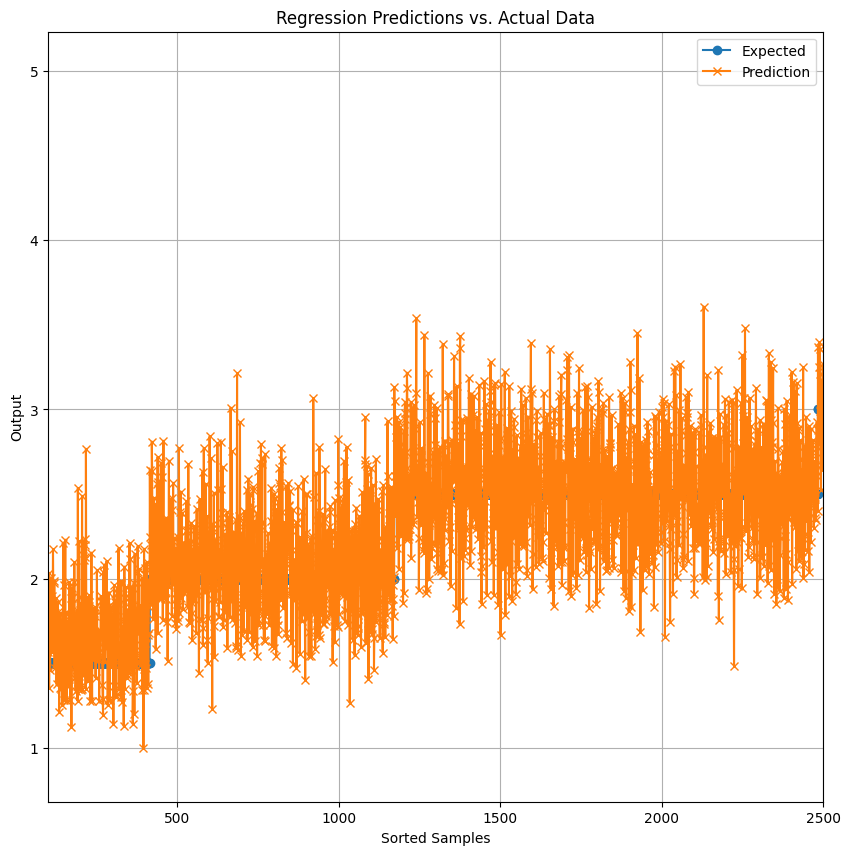

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 10]

def chart_regression(pred, y, sort=True, x_limits=None):
    if isinstance(y, pd.Series):
        y = y.ravel()
    else:
        y = y.flatten()

    t = pd.DataFrame({'pred': pred, 'y': y})
    
    if sort:
        t.sort_values(by=['y'], inplace=True)
    
    # Plotting data
    plt.figure()
    plt.plot(t['y'].tolist(), label='Expected', marker='o')
    plt.plot(t['pred'].tolist(), label='Prediction', marker='x')
    plt.ylabel('Output')
    plt.xlabel('Sorted Samples')
    plt.title('Regression Predictions vs. Actual Data')
    plt.legend()
    plt.grid(True)
    
    if x_limits:
        plt.xlim(x_limits[0], x_limits[1])

    plt.show()

chart_regression(best_predicted_model.flatten(), y_test_copy, sort=True, x_limits=(100, 2500))

